In [8]:
from model import build_time_series_ds, build_tft
from config import get_config
from levels import level_id, level_id_dates
import numpy as np
import pandas as pd

from IPython.display import clear_output
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet


def rmsse_scores(model_path):

    config_folder = model_path[-6]

    config = get_config()

    _, _, ds_train, _ = build_time_series_ds(config)

    dsp = ds_train.get_parameters()
    dsp["predict_mode"] = True

    df, _ = level_id_dates(config["level"], True, False)
    dft,_ = level_id_dates(config['level'],True,True)
    dft.time_idx += 1941
    dft.value = 0

    pred_outline = pd.concat([df, dft]).fillna(0)
    pred_outline.wday = pred_outline.wday.astype(str)
    pred_outline.month = pred_outline.month.astype(str)
    pred_outline.reset_index(drop=True,inplace=True)
    pred_outline.value = pred_outline.value.astype(float)

    new_prediction_data = TimeSeriesDataSet.from_parameters(dsp, pred_outline)

    tft = TemporalFusionTransformer.load_from_checkpoint(model_path)

    raw_preds = tft.predict(
        new_prediction_data, mode="raw", return_x=True,num_workers=32
    )  

    clear_output()

    labels = {
        outer_k: {v: k for k, v in tft.hparams.embedding_labels[outer_k].items()}
        for outer_k in tft.hparams.static_categoricals
    }
    groups = raw_preds[1]["groups"].cpu().numpy()

    labels_list = list(labels.values())
    new_groups = []

    for group in groups:
        new_group = []
        for i, item in enumerate(group):

            dict_to_use = labels_list[i % len(labels_list)]
            new_value = dict_to_use.get(item, None)
            new_group.append(new_value)
        new_groups.append(new_group)

    groups = np.array(new_groups, dtype=object)

    preds = raw_preds[0].prediction

    df_preds = pd.DataFrame()

    for g in range(len(groups)):
        p = preds[g][:, 3].cpu().numpy()
        col = tuple(groups[g])
        df_preds[col] = p

    df_preds = df_preds.round(0)
    df_preds.index = df_preds.index + 1942
    df_preds = df_preds[:-2].astype(int)

    ## true data -----------------------
    df, identifiers = level_id(config["level"], test=True)
    df_true = df.pivot_table(index="date", columns=identifiers, values="value")

    # loss -------------------------------------

    df_preds = df_preds.reset_index(drop=True)
    df_true = df_true.reset_index(drop=True)

    df_preds.columns = [
        col[0] if isinstance(col, tuple) and len(col) == 1 else col
        for col in df_preds.columns
    ]
    df_true.columns = [
        col[0] if isinstance(col, tuple) and len(col) == 1 else col
        for col in df_true.columns
    ]

    mse = ((df_true - df_preds) ** 2).mean()

    historical_diffs = df_true.diff().iloc[1:]
    scaling_factors = (historical_diffs**2).mean()

    scaling_factors = scaling_factors.replace(0, np.nan)

    rmsse = np.sqrt(mse / scaling_factors).mean()

    return rmsse, df_preds,df_true,tft,raw_preds,mse,scaling_factors


In [9]:
rmsse, df_preds, df_true,model,raw_preds,mse,scaling = rmsse_scores(
    "checkpoints/7/epoch=3-val_loss=184.64-7.ckpt"
)
rmsse

1.1874592179565124

In [13]:
scaling

(CA, FOODS_1)        3.584678e+04
(CA, FOODS_2)        1.253132e+05
(CA, FOODS_3)        1.486907e+06
(CA, HOBBIES_1)      4.569693e+04
(CA, HOBBIES_2)      1.337704e+03
(CA, HOUSEHOLD_1)    2.881441e+05
(CA, HOUSEHOLD_2)    3.592278e+04
(TX, FOODS_1)        1.020730e+04
(TX, FOODS_2)        5.886359e+04
(TX, FOODS_3)        7.577653e+05
(TX, HOBBIES_1)      4.417211e+04
(TX, HOBBIES_2)      6.266667e+02
(TX, HOUSEHOLD_1)    1.370645e+05
(TX, HOUSEHOLD_2)    1.182619e+04
(WI, FOODS_1)        1.882522e+04
(WI, FOODS_2)        2.337128e+05
(WI, FOODS_3)        9.636197e+05
(WI, HOBBIES_1)      4.167111e+04
(WI, HOBBIES_2)      5.918148e+02
(WI, HOUSEHOLD_1)    1.776490e+05
(WI, HOUSEHOLD_2)    6.939778e+03
dtype: float64

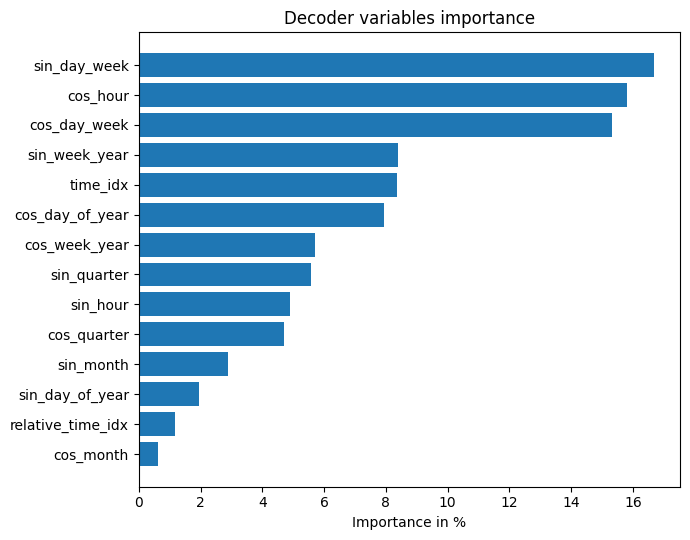

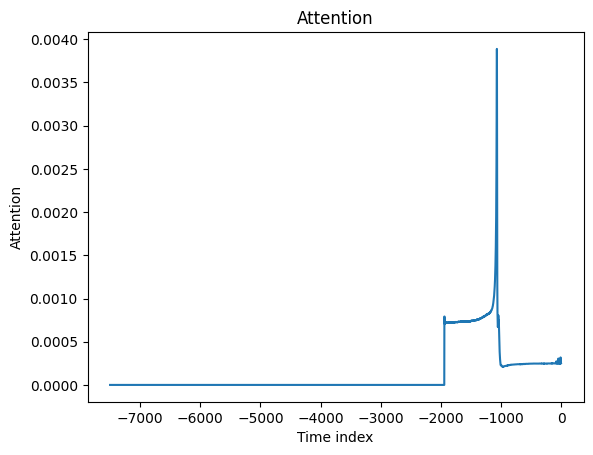

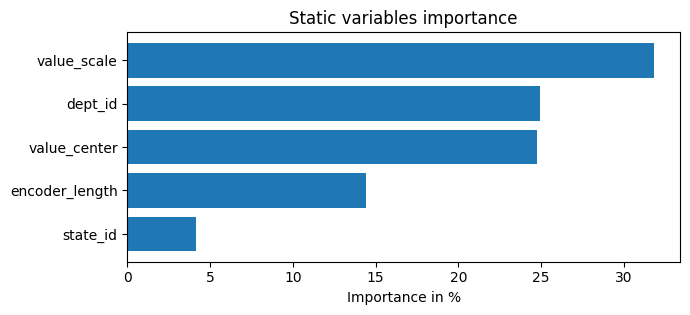

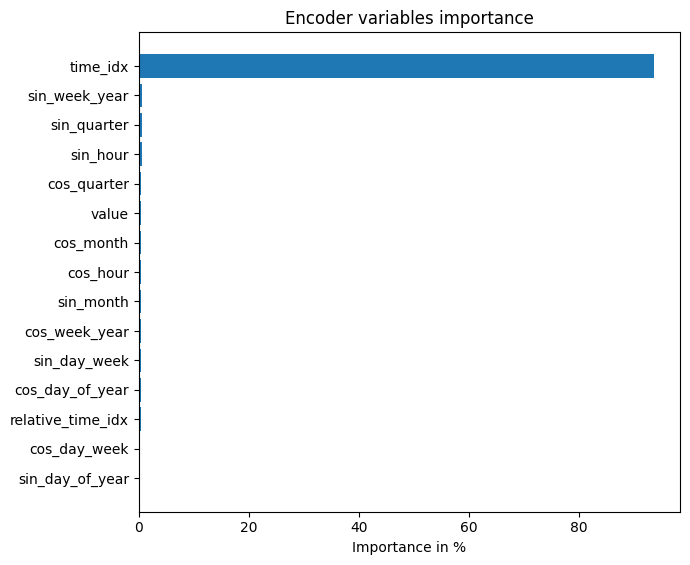

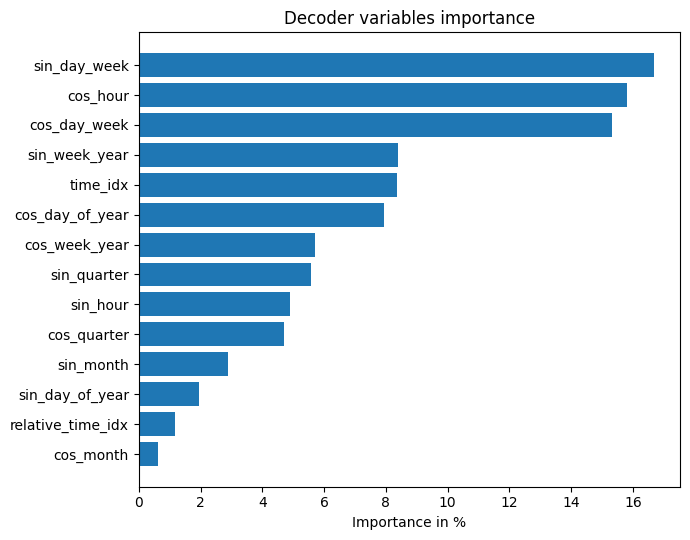

In [3]:
interpretation = model.interpret_output(raw_preds.output,reduction="sum")

model.plot_interpretation(interpretation)['decoder_variables']

In [69]:
x = interpretation['attention'].cpu().numpy() 
x = x[x != 0]

In [70]:
x

array([0.01823314, 0.01937115, 0.01975161, ..., 0.00621961, 0.00633082,
       0.00629355], dtype=float32)

In [66]:
df = pd.DataFrame(x,columns=["value"])
#df["days_before_present"] = sorted(np.arange(0,len(df)))

In [67]:
df

,value
0,0.018233
1,0.019371
2,0.019752
3,0.019351
4,0.018675
...,...
1936,0.006233
1937,0.006232
1938,0.006220
1939,0.006331


<Axes: xlabel='days_before_present'>

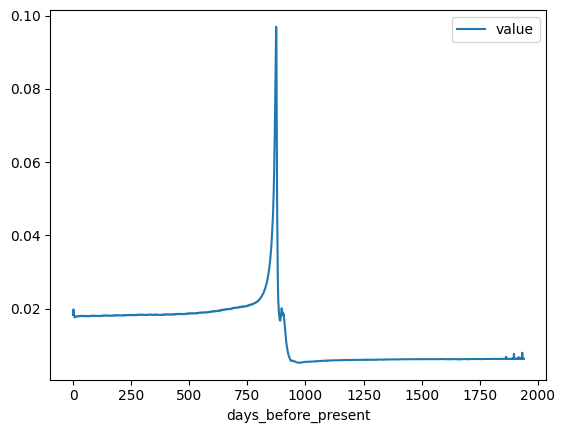

In [65]:
df.plot(x='days_before_present',y='value')

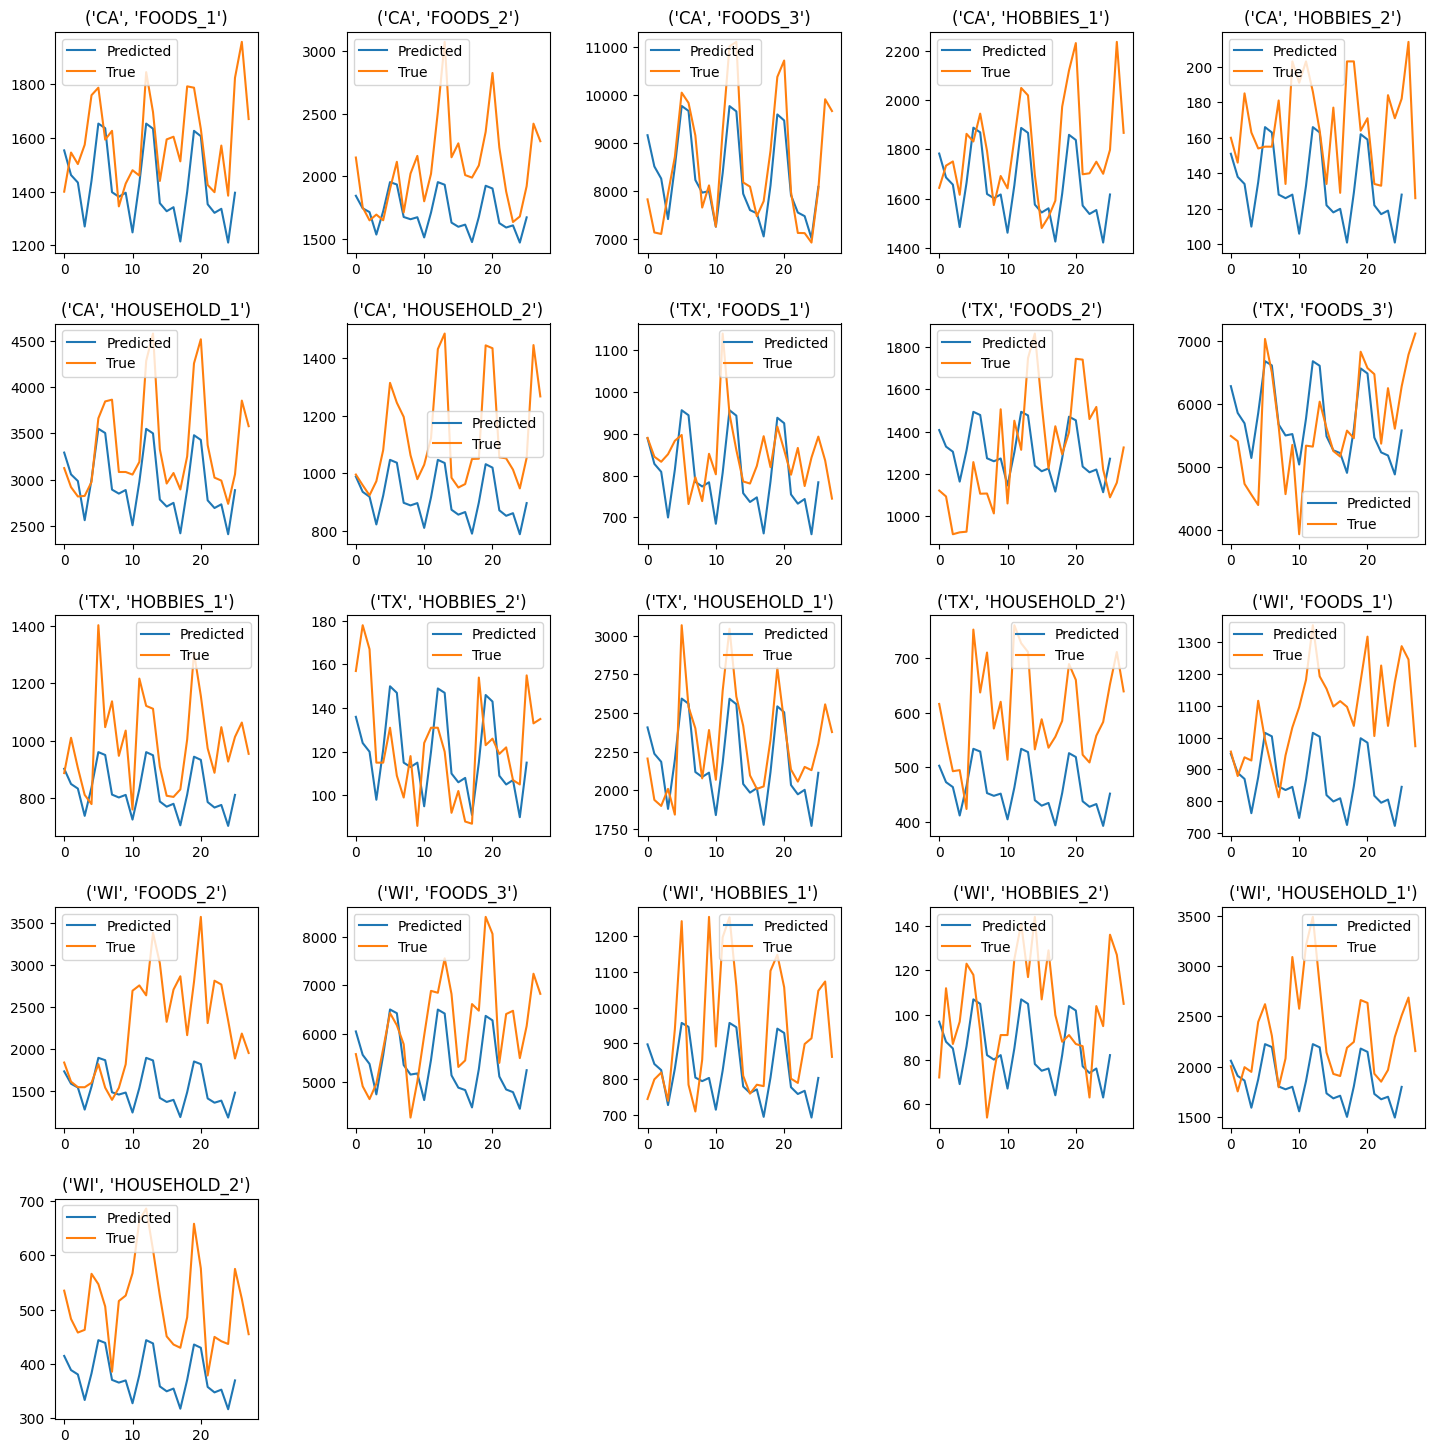

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of rows and columns for the subplot grid
n_cols = len(df_preds.columns)
n_rows = int(
    np.ceil(np.sqrt(n_cols))
)  # Ensure at least enough rows to accommodate all columns
n_cols = n_rows  # Making a square grid to accommodate all plots

fig, axs = plt.subplots(
    n_rows, n_cols, figsize=(15, n_rows * 3)
)  # Adjusting figure size dynamically
fig.tight_layout(pad=3.0)  # Add spacing between plots

for idx, col in enumerate(df_preds.columns):
    ax = axs.flatten()[idx]  # Flatten the array of axes to easily iterate over it
    ax.plot(df_preds[col], label="Predicted")
    ax.plot(df_true[col], label="True")
    ax.set_title(col)
    ax.legend()

# Hide unused subplots if any
for idx in range(len(df_preds.columns), n_rows * n_cols):
    axs.flatten()[idx].set_visible(False)

plt.show()

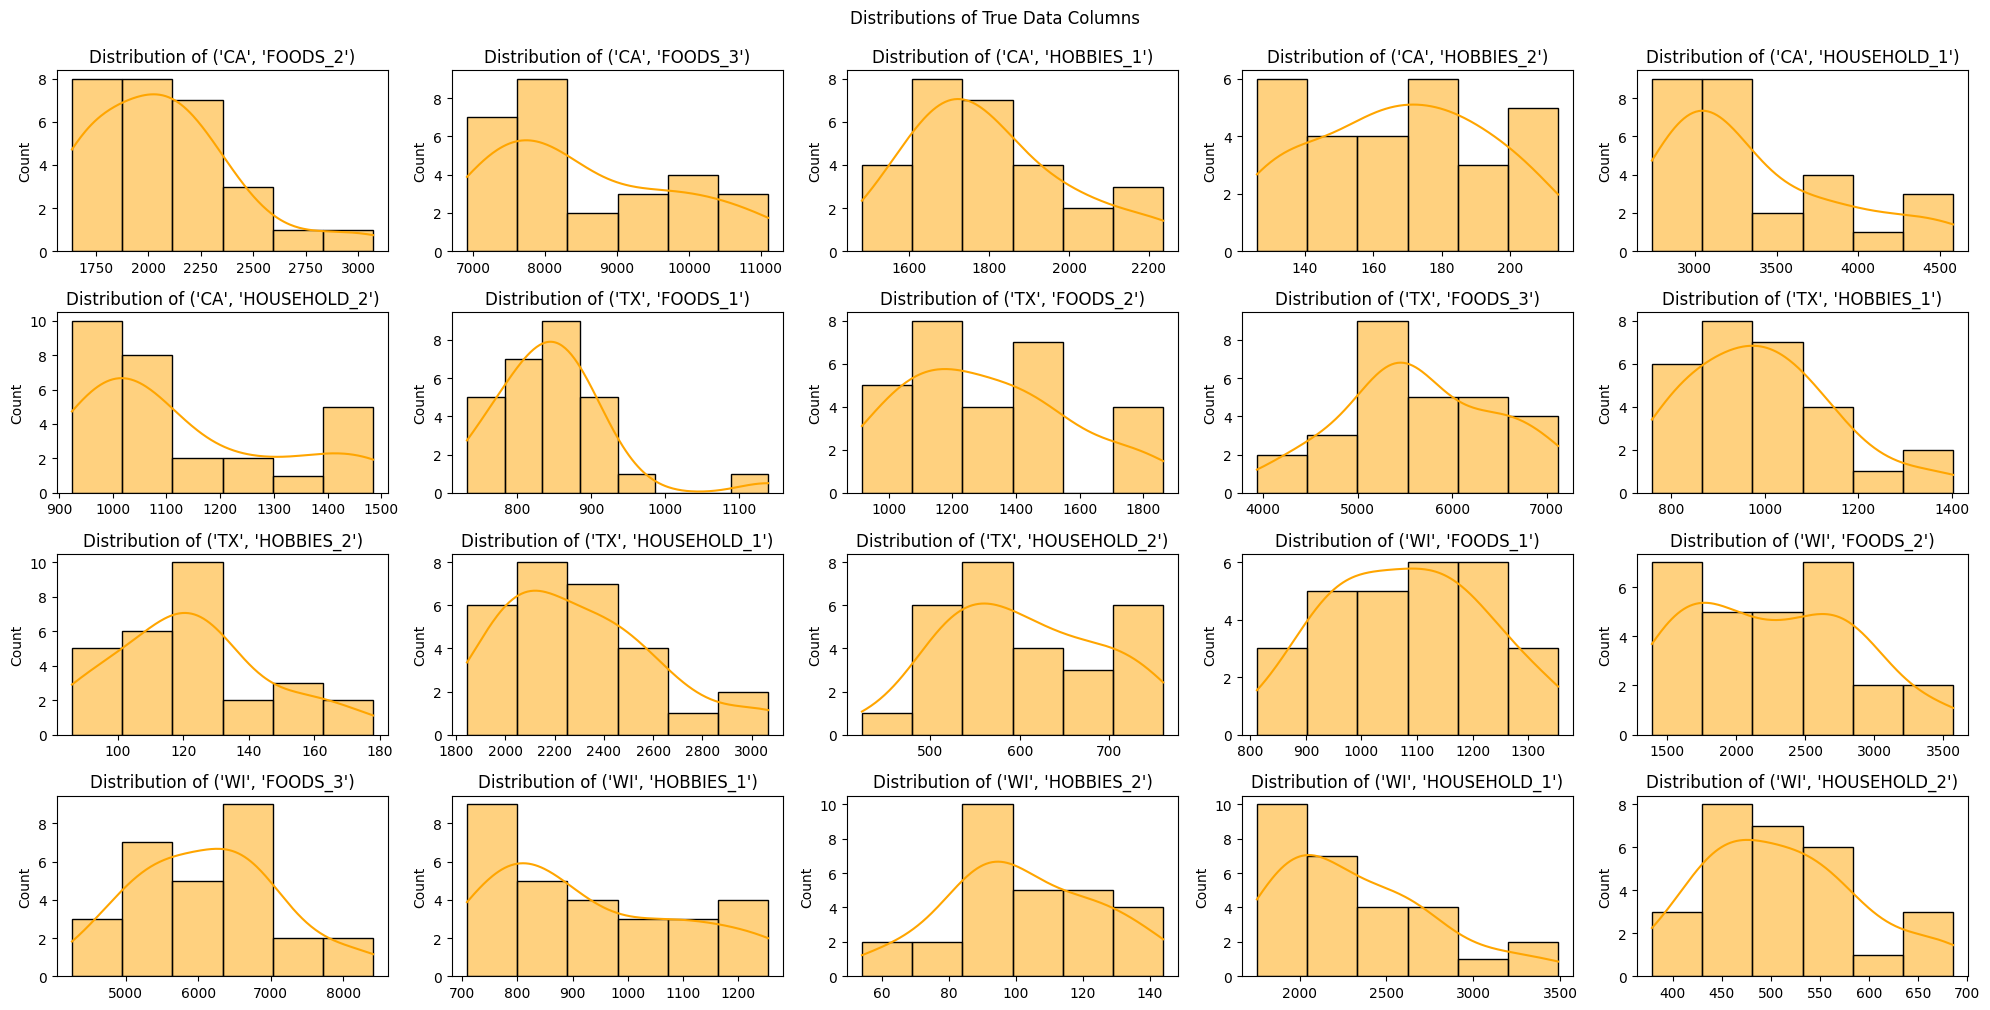

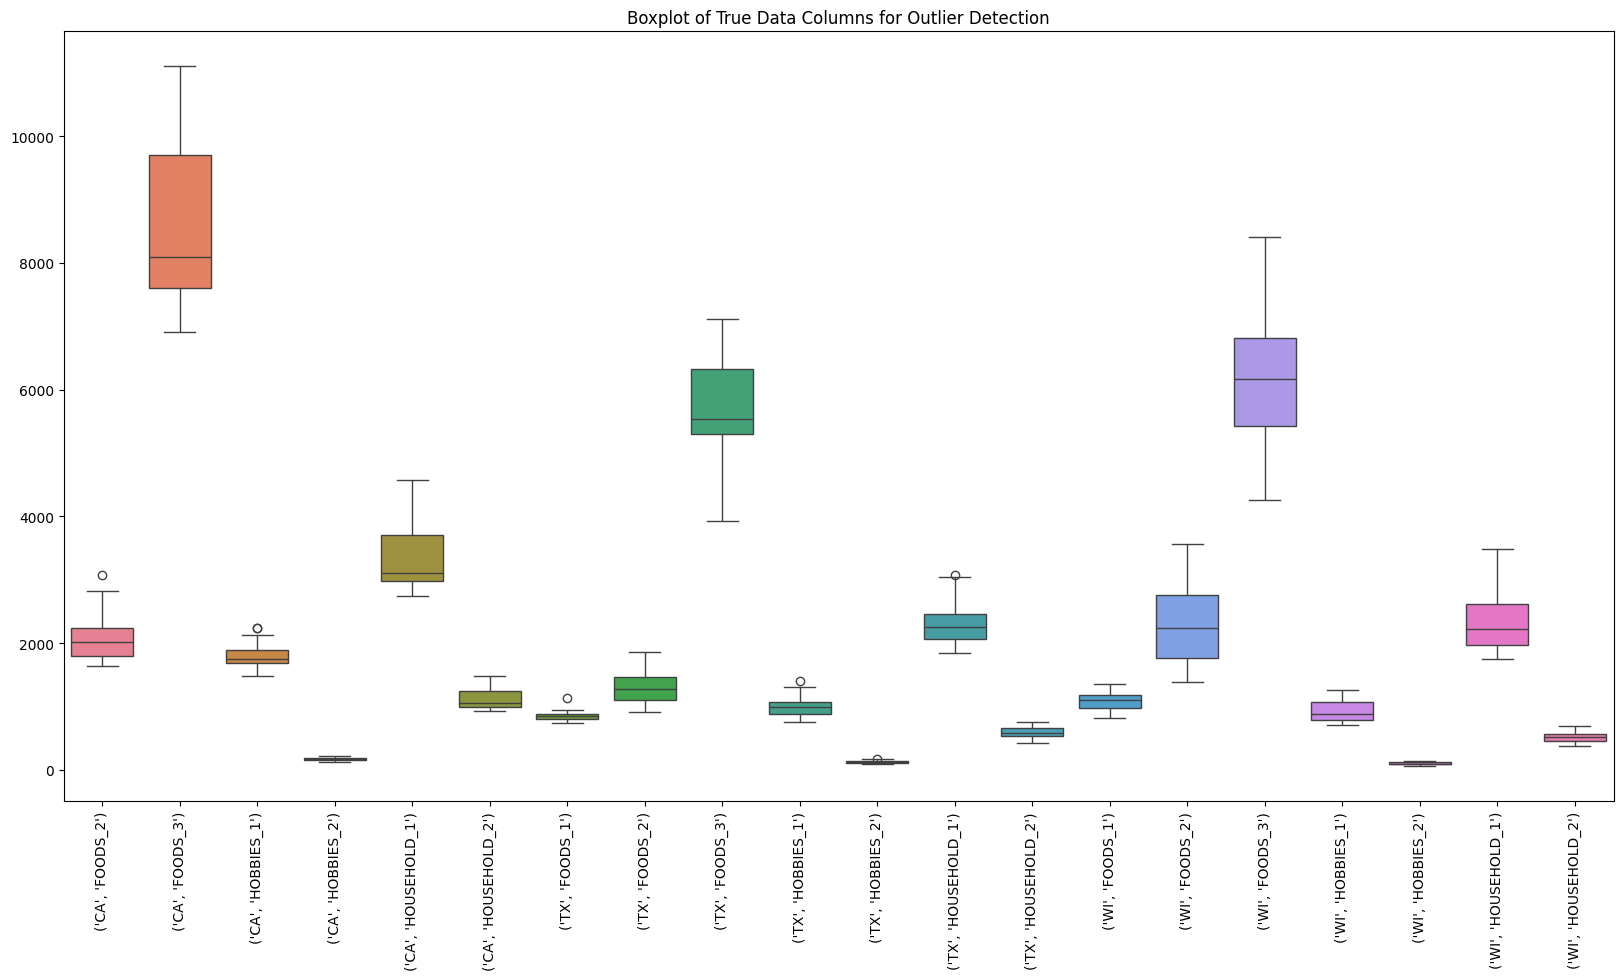

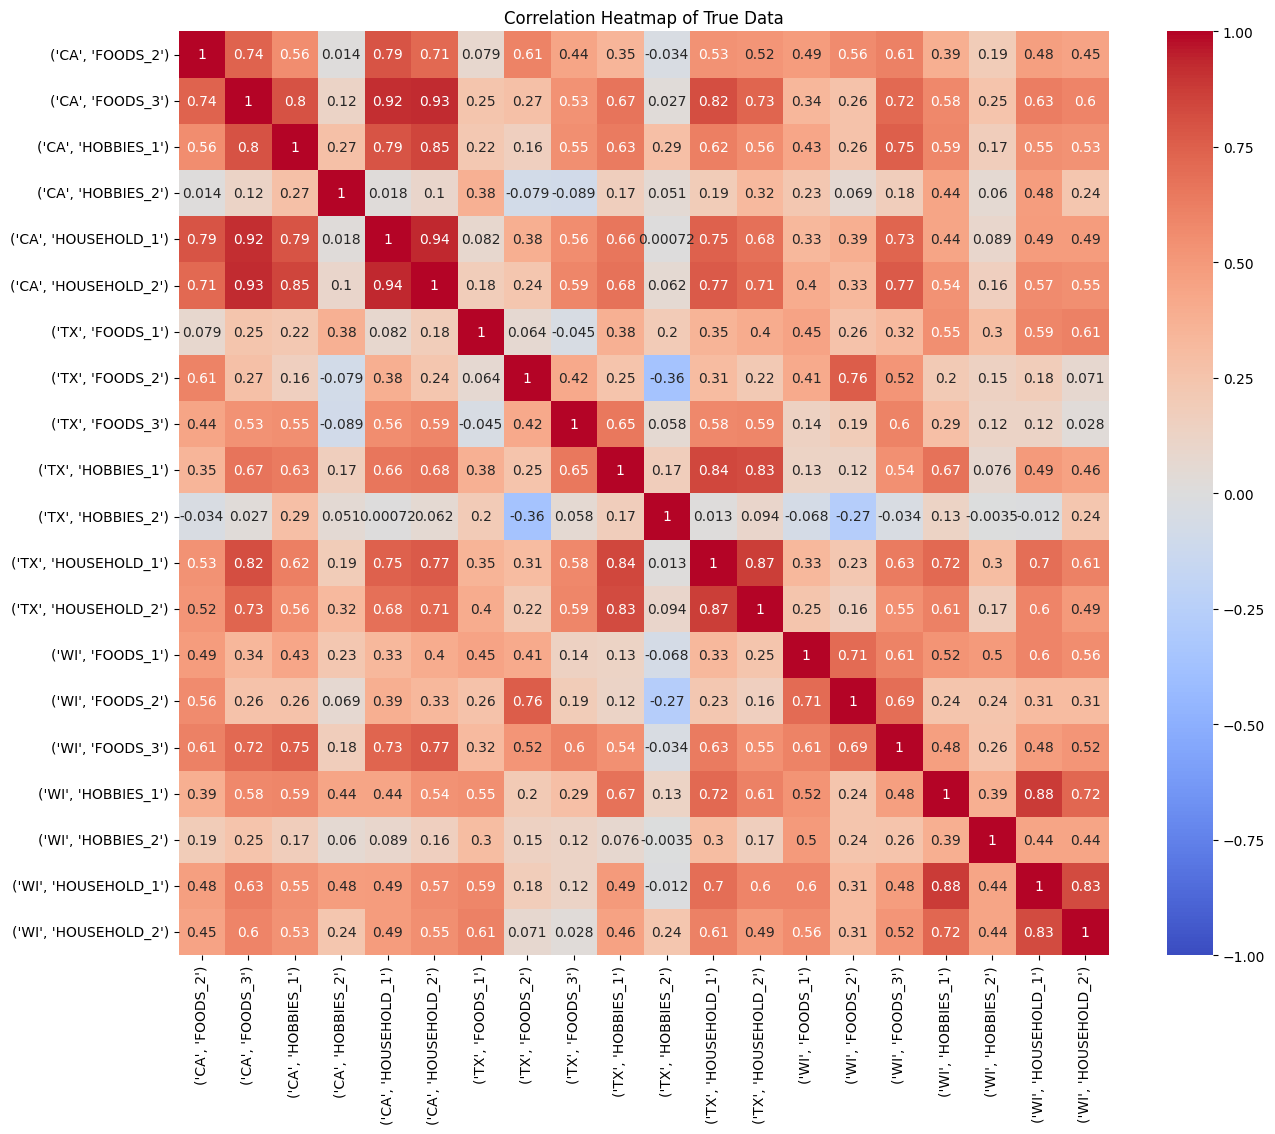

                       count         mean          std     min      25%  \
('CA', 'FOODS_1')       28.0  1594.785714   163.492067  1345.0  1455.00   
('CA', 'FOODS_2')       28.0  2069.392857   351.774164  1636.0  1789.00   
('CA', 'FOODS_3')       28.0  8578.321429  1300.303129  6917.0  7601.75   
('CA', 'HOBBIES_1')     28.0  1798.928571   198.690888  1481.0  1680.00   
('CA', 'HOBBIES_2')     28.0   168.035714    25.816277   126.0   152.00   
('CA', 'HOUSEHOLD_1')   28.0  3363.964286   538.828392  2737.0  2985.25   
('CA', 'HOUSEHOLD_2')   28.0  1125.428571   181.349352   924.0   983.75   
('TX', 'FOODS_1')       28.0   846.785714    78.807011   732.0   800.50   
('TX', 'FOODS_2')       28.0  1304.607143   265.890724   916.0  1103.75   
('TX', 'FOODS_3')       28.0  5668.321429   828.169559  3933.0  5307.50   
('TX', 'HOBBIES_1')     28.0   994.642857   158.815107   760.0   887.75   
('TX', 'HOBBIES_2')     28.0   122.464286    23.853693    86.0   106.50   
('TX', 'HOUSEHOLD_1')   2

In [9]:
import seaborn as sns


true_data_summary = df_true.describe().transpose()
df_true.columns = [str(col) for col in df_true.columns]
# Visualizations for deeper understanding
plt.figure(figsize=(20, 12))

# Distribution plots for all columns in the true data
for i, col in enumerate(df_true.columns[1:], 1):
    plt.subplot(5, 5, i)
    sns.histplot(df_true[col], kde=True, color='orange')
    plt.title(f"Distribution of {col}")
    plt.xlabel('')
    plt.tight_layout()

plt.suptitle("Distributions of True Data Columns", y=1.02)
plt.show()

# Boxplots for detecting outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_true.iloc[:, 1:])
plt.xticks(rotation=90)
plt.title("Boxplot of True Data Columns for Outlier Detection")
plt.show()

# Correlation heatmap to assess relationships between columns
plt.figure(figsize=(15, 12))
sns.heatmap(df_true.iloc[:, 1:].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of True Data")
plt.show()

# Display the summary statistics to the user
print(true_data_summary)

In [5]:
#pip install pandas

In [6]:
import pandas as pd

df = pd.read_csv("data/sales_train_evaluation.csv").sample(10000)

In [7]:
df.to_csv("sales_train_eval_sample.csv")